<h3>Serov Alexander BS-81</h3>
<h4>KRAB</h4>

In [184]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [185]:
data = pd.read_excel('diabet.xlsx').to_numpy()
data

array([[ 29,  38, 121],
       [ 46,  48, 218],
       [ 49,  57, 256],
       ...,
       [ 33,  40, 167],
       [ 41,  48, 197],
       [ 49,  58, 220]])

In [186]:
def squared_distance(x1, x2):
    s = 0
    for i in range(len(x1)):
        s += (x1[i]-x2[i])**2
    return s

In [187]:
def get_assignments(passed, farthest_pairs):
    current_cluster = 0
    
    # idx of data point and no of cluster
    assignments = np.zeros(len(passed))
    
    for point in passed:
        assignments[point] = current_cluster
        for p1, p2 in farthest_pairs:
            if point == p1:
                current_cluster += 1
    
    return assignments
    

In [188]:
def get_farthest_pair(k, edges_with_dist):
    farthest_pairs = []
    
    for _ in range(k-1):
        max_dist = 0
        max_pair = None
        for edge in edges_with_dist:
            pair = (edge[0], edge[1])
            dist = edge[-1]
            if pair not in farthest_pairs:
                if dist > max_dist:
                    max_dist = dist
                    max_pair = pair
        farthest_pairs.append(max_pair)
        
    return farthest_pairs

In [189]:
def get_ro(k, edges_with_dist, assignments):
    ro_i = np.zeros(k)
    
    for i in range(k):
        m = 0
        s = 0
        for p1, p2, dist in edges_with_dist:
            if assignments[p1] == assignments[p2] == i:
                s += dist
                m += 1
        ro_i[i] = s/m
    
    ro = ro_i.mean()
    return ro

In [190]:
def get_d(edges_with_dist, assignments):
    d_i = []
    
    for p1, p2, dist in edges_with_dist:
        if assignments[p1] != assignments[p2]:
            d_i.append(dist)
    
    d = np.asarray(d_i).mean()
    return d

In [191]:
def get_lambda(edges_with_dist, assignments):
    lambda_i = []
    
    for i, (p1, p2, dist) in enumerate(edges_with_dist):
        if assignments[p1] != assignments[p2]:
            if p1 == edges_with_dist[0][0]:
                closest_min_dist = edges_with_dist[1][-1]
            elif p2 == edges_with_dist[-1][0]:
                closest_min_dist = edges_with_dist[-2][-1]
            else:
                closest_min_dist = min(
                    edges_with_dist[i+1][-1],
                    edges_with_dist[i-1][-1],
                )
            lambda_i.append(closest_min_dist/dist)
    
    lambda_ = np.asarray(lambda_i).mean()
    return lambda_

In [192]:
def get_h(k, M, assignments):
    h = k**k
    
    for i in range(k):
        m_i = 0
        for ass in assignments:
            if ass == i:
                m_i += 1
        h *= m_i/M
    
    return h
    

In [193]:
def get_F(ro, d, lambda_, h):
    return np.log(d*h/(ro*lambda_))
    

In [194]:
def KRAB(data, k=2, distance=squared_distance):
    current_idx = np.random.randint(0, data.shape[0])
    passed = [current_idx]
    edges_with_dist = []
    
    for _ in range(len(data)-1):
        dist = np.inf
        closest_idx = 0
        for i in range(len(data)):
            if i not in passed:
                new_dist = distance(data[current_idx], data[i])
                if new_dist < dist:
                    dist = new_dist
                    closest_idx = i
        passed.append(closest_idx)
        edges_with_dist.append([current_idx, closest_idx, dist])
        current_idx = closest_idx
        
    farthest_pairs = get_farthest_pair(k, edges_with_dist)
    
    assignments = get_assignments(passed, farthest_pairs)
    
    ro = get_ro(k, edges_with_dist, assignments)
    d = get_d(edges_with_dist, assignments)
    lambda_ = get_lambda(edges_with_dist, assignments)
    h = get_h(k, len(data), assignments)
    F = get_F(ro, d, lambda_, h)
    
    return assignments, F, (ro, d, lambda_, h), edges_with_dist

In [195]:
ass, F, params, steps = KRAB(data)

In [196]:
steps[:30]

[[326, 185, 1],
 [185, 374, 2],
 [374, 110, 3],
 [110, 252, 3],
 [252, 162, 6],
 [162, 325, 11],
 [325, 155, 6],
 [155, 317, 4],
 [317, 201, 2],
 [201, 364, 8],
 [364, 39, 8],
 [39, 1, 17],
 [1, 356, 22],
 [356, 290, 5],
 [290, 158, 3],
 [158, 347, 10],
 [347, 80, 10],
 [80, 382, 14],
 [382, 111, 26],
 [111, 292, 18],
 [292, 129, 4],
 [129, 137, 6],
 [137, 78, 13],
 [78, 385, 5],
 [385, 131, 19],
 [131, 288, 21],
 [288, 49, 24],
 [49, 340, 10],
 [340, 98, 4],
 [98, 383, 6]]

In [197]:
F

7.277450265303864

In [198]:
pd.DataFrame(params, index=['ro', 'd', 'lambda', 'h'], columns=['val'])

,val
ro,29.492683
d,3852.000000
lambda,0.052700
h,0.583975


In [199]:
def plot_clusters(data, cluster_markers, k=2):
    palette = plt.cm.get_cmap('hsv', k+1)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    for i in range(len(data)):
        x, y, z = data[i]
        ax.scatter(x, y, z, color=palette(int(cluster_markers[i])))
    ax.set_xlabel('Waist')
    ax.set_ylabel('Thigh')
    ax.set_zlabel('Weight')

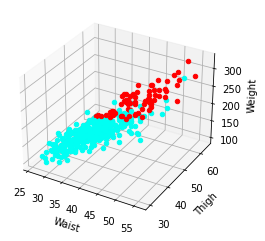

In [200]:
plot_clusters(data, ass)

<h4>Вывод</h4>

Критерий качества F с нашими данными про вес, талию и бедра колеблиться ~ от 4 до 8.

На графике заметно качественное разбиение данных на 2 класса, с единичными выкидами.
Для линейного алгоритма KRAB это являеться стандартной практикой, из-за случайности выбора первых точек.